# Проект: классификация

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot
%matplotlib inline

import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

import optuna
import hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

Данные о клиентах банка:

    age (возраст);
    job (сфера занятости);
    marital (семейное положение);
    education (уровень образования);
    default (имеется ли просроченный кредит);
    housing (имеется ли кредит на жильё);
    loan (имеется ли кредит на личные нужды);
    balance (баланс).
    
Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

    contact (тип контакта с клиентом);
    month (месяц, в котором был последний контакт);
    day (день, в который был последний контакт);
    duration (продолжительность контакта в секундах).

Прочие признаки:

    campaign (количество контактов с этим клиентом в течение текущей кампании);
    pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
    previous (количество контактов до текущей кампании)
    poutcome (результат прошлой маркетинговой кампании).

И, разумеется, наша целевая переменная deposit, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

### Задание 1

In [41]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [43]:
df.isna().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [44]:
df['job'].unique()

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

### Задание 3

In [45]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
def balance_convert(row):
    row = str(row)
    if row != np.NaN:
        row = row.replace(',00', '')
        row = row.replace('$', '')
        row = row.replace(' ', '')
        return float(row)
    else:
        return np.nan
    
df['balance'] = df['balance'].apply(balance_convert)

round(df['balance'].mean(), 3)

1529.129

### Задание 4

In [46]:
# обработайте пропуски в признаки balance, заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())
round(df['balance'].mean(), 3)

1526.936

### Задание 5

In [47]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
moda_job = df['job'].mode()[0]
df['job'] = df['job'].apply(lambda x: moda_job if x == 'unknown' else x)

moda_education = df['education'].mode()[0]
df['education'] = df['education'].apply(lambda x: moda_education if x == 'unknown' else x)

# средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования
df_balance = df[(df.job == moda_job) & (df.education == moda_education)]
round(df_balance['balance'].mean(), 3)

1598.883

### Задание 6

In [48]:
# удалите все выбросы для признака balance
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return lower_bound, upper_bound, cleaned, outliers

lower_bound, upper_bound, cleaned, outliers = outliers_iqr(df, 'balance')
print(f'Верхняя граница: {upper_bound}')
print(f'Нижняя граница: {lower_bound}')
print(f'Результирующее число записей: {cleaned.shape[0]}')
df = df.drop(outliers.index)

Верхняя граница: 4063.0
Нижняя граница: -2241.0
Результирующее число записей: 10105


## Часть 2:  Разведывательный анализ

### Задание 1

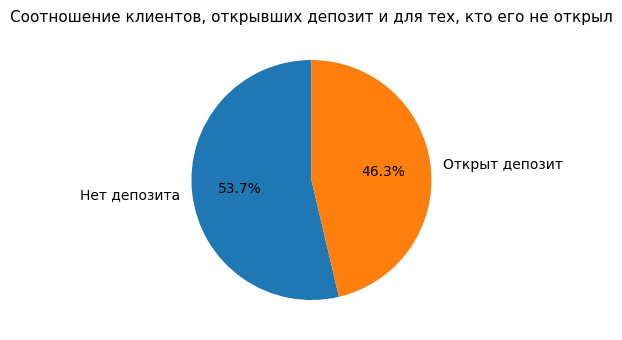

no     5424
yes    4681
Name: deposit, dtype: int64

In [49]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
#визуализация главного графика
fig = plt.figure(figsize=(5, 3))
ax = fig.add_axes((1, 1, 1, 1))
deposit_count = df['deposit'].value_counts().sort_values(ascending=False)
pie = ax.pie(
    deposit_count,
    labels=['Нет депозита', 'Открыт депозит'],
    autopct='%1.1f%%',
    startangle=90
)
title = ax.set_title('Соотношение клиентов, открывших депозит и для тех, кто его не открыл', fontsize=11)
plt.show(pie)

df["deposit"].value_counts()

При рассмотрении графика распределения целевой переменной (депозит), можно сказать, что несбалансированность классов совсем незначительная.

### Задания 2 и 3

In [50]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
print('Максимальный возраст клиента банка:', df["age"].max())
print('Минимальная продолжительность разговора с клиентом банка в сек:', df["duration"].min())

df.describe()

Максимальный возраст клиента банка: 95
Минимальная продолжительность разговора с клиентом банка в сек: 2


,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


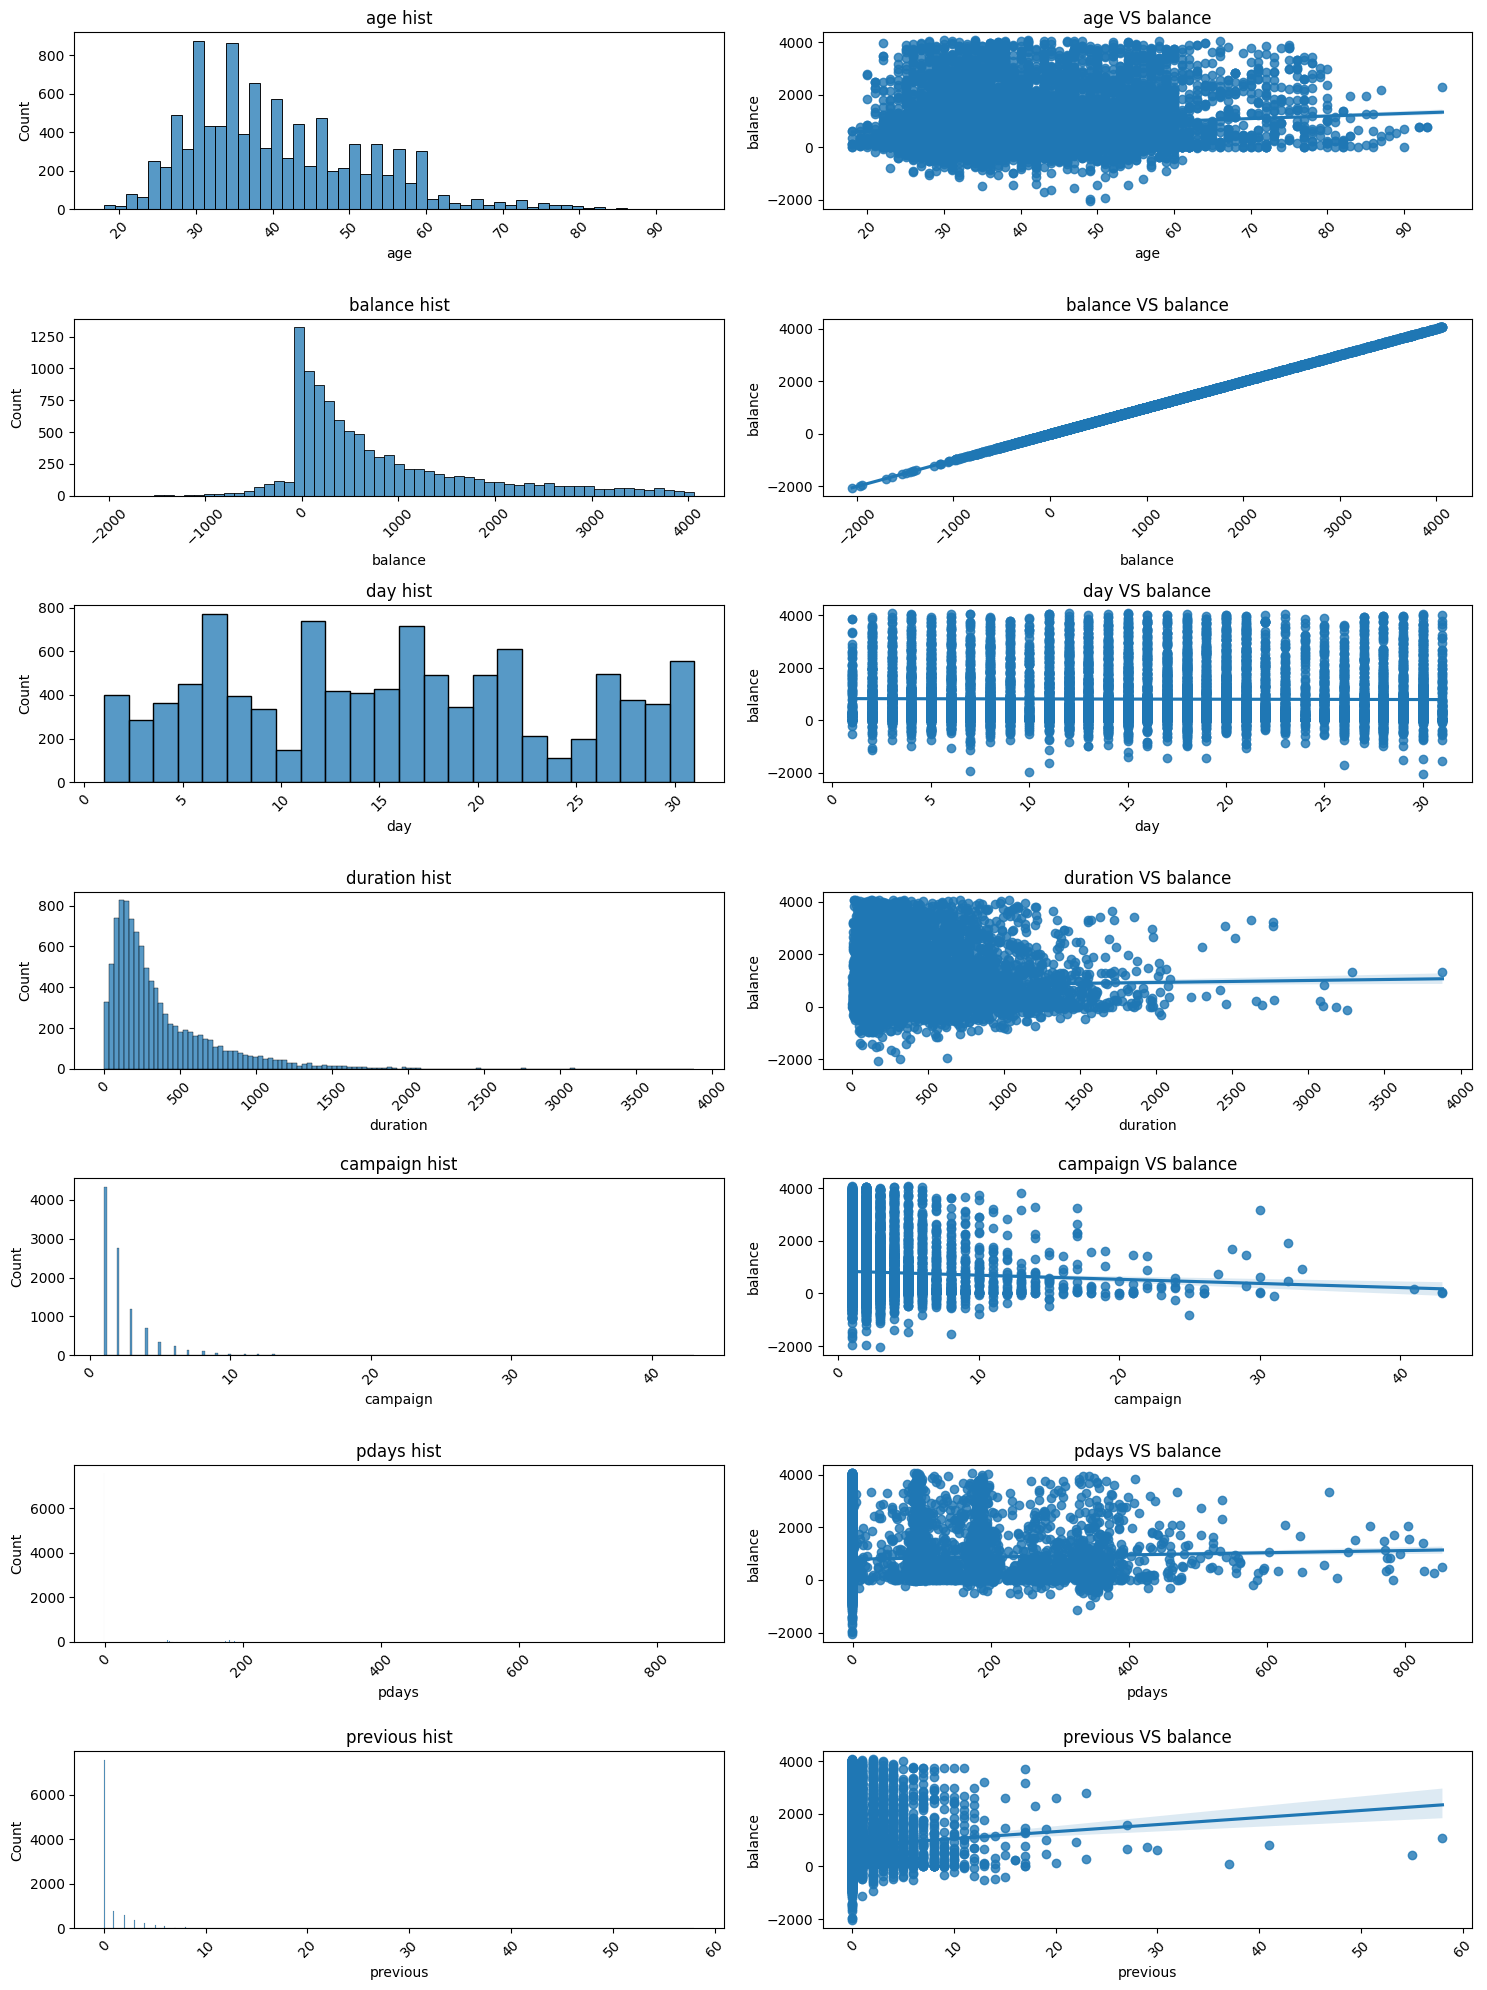

In [12]:
#выделяем имена числовых признаков в виде списка для удобства дальнейшей работы
types = df.dtypes
num_features = list(types[(types != 'object')].index)

n = len(num_features) #количество числовых признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 20)) # фигура + n х 2 координатных плоскостей
#Создаем цикл для всех признаков из списка числовых признаков
for i, feature in enumerate(num_features): #i- индекс, feature - название признака в таблице
    #Строим гистограмму распределения признака 
    histplot = sns.histplot(data=cleaned, x=feature, ax=axes[i][0])
    #Добавляем подпись графику
    histplot.set_title('{} hist'.format(feature))
    #Добавляем поворот отметок на оси абсцисс
    histplot.xaxis.set_tick_params(rotation=45)
    #Строим диаграмму рассеяния + линейную регрессию
    regplot = sns.regplot(data=cleaned, x=feature, y='balance', ax=axes[i][1])
    #Добавляем подпись графику
    regplot.set_title('{} VS balance'.format(feature))
    #Добавляем поворот отметок на оси абсцисс
    regplot.xaxis.set_tick_params(rotation=45)
plt.tight_layout() #выравнивание графиков

### Задания 4 и 5

In [51]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
print('Сколько было месяцев, в которых проводилась маркетинговая кампания:', df["month"].nunique())
print('Сколько сфер занятости представлено среди клиентов банка:', df["job"].nunique())

cleaned.describe(include='object')

Сколько было месяцев, в которых проводилась маркетинговая кампания: 12
Сколько сфер занятости представлено среди клиентов банка: 11


,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


In [52]:
df['poutcome'].value_counts()

unknown    7570
failure    1109
success     945
other       481
Name: poutcome, dtype: int64

### Задание 6

In [53]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
df.groupby('poutcome')['previous'].value_counts()

poutcome  previous
failure   1            368
          2            293
          3            163
          4             92
          5             56
                      ... 
success   13             2
          15             1
unknown   0           7568
          1              1
          2              1
Name: previous, Length: 66, dtype: int64

### Задание 7

In [54]:
group = df.groupby(df['poutcome'] == 'failure', as_index=False)['month'].value_counts()
print(group)

    poutcome month  count
0      False   may   2282
1      False   jul   1376
2      False   aug   1301
3      False   jun   1056
4      False   apr    680
5      False   nov    641
6      False   feb    582
7      False   jan    280
8      False   oct    273
9      False   sep    232
10     False   mar    211
11     False   dec     82
12      True   may    335
13      True   apr    150
14      True   nov    139
15      True   feb    127
16      True   aug     84
17      True   oct     62
18      True   jun     48
19      True   sep     46
20      True   jul     42
21      True   jan     39
22      True   mar     26
23      True   dec     11


### Задание 8

In [55]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def get_age (arg):
    if arg < 30:
        return '<30'
    elif (arg >= 30) and (arg < 40):
        return '30-40'
    elif (arg >= 40) and (arg < 50):
        return '40-50'
    elif (arg >= 50) and (arg < 60):
        return '50-60'
    else:
        return '60+'

df['age_new'] = df['age'].apply(get_age)

In [56]:
# распределение возраста в разрезе признака открытия депозита
fig = px.histogram(
data_frame=df,
x='age_new',
color='deposit',
histfunc='count',
title='Распределение возраста клиентов в разрезе признака открытия депозита',
nbins = 30
)
fig.show()

### Задания 9 и 10

In [57]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
fig = px.histogram(
data_frame=df,
x='marital',
color='deposit',
histfunc='count',
title='Распределение семейного статуса в разрезе признака открытия депозита',
nbins = 30
)
fig.show()

In [58]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
fig = px.histogram(
data_frame=df,
x='education',
color='deposit',
histfunc='count',
title='Распределение образования в разрезе признака открытия депозита',
nbins = 30
)
fig.show()

In [59]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
fig = px.histogram(
data_frame=df,
x='job',
color='deposit',
histfunc='count',
title='Распределение вида профессиональной занятости в разрезе признака открытия депозита',
nbins = 30
)
fig.show()

### Задание 11

In [60]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
dep_yes = df['deposit'] == 'yes'
dep_no = df['deposit'] == 'no'

df[dep_yes].pivot_table(
    values='deposit',
    index='education',
    columns='marital',
    aggfunc='count'
).iplot(kind='bar',
        histnorm='percent',
        barmode='group',
        xTitle='Образование и семейный статус',
        yTitle='Количество клиентов, открывших депозит', 
        title='Сводная диаграмму по уровню образования и семейному положению (есть депозит)'
        )

In [61]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто НЕ открыл депозит)
df[dep_no].pivot_table(
    values='deposit',
    index='education',
    columns='marital',
    aggfunc='count'
).iplot(kind='bar',
        histnorm='percent',
        barmode='group',
        xTitle='Образование и семейный статус',
        yTitle='Количество клиентов, открывших депозит', 
        title='Сводная диаграмму по уровню образования и семейному положению (нет депозита)'
        )

## Часть 3: преобразование данных

### Задание 1

In [62]:
# преобразуйте уровни образования
from sklearn.preprocessing  import LabelEncoder

le = LabelEncoder()
df['education'] = le.fit_transform(df['education'])

df['education'].sum()

11995

### Задания 2 и 3

In [63]:
# преобразуйте бинарные переменные в представление из нулей и единиц
le = LabelEncoder()
df.age_new = le.fit_transform(df.age_new)

def get_binar (arg):
    if arg == 'yes':
        return 1
    else:
        return 0
  
df['deposit'] = df['deposit'].apply(get_binar)
df['default'] = df['default'].apply(get_binar)
df['housing'] = df['housing'].apply(get_binar)
df['loan'] = df['loan'].apply(get_binar)

print('стандартное отклонение целевой переменной deposit:', round(df['deposit'].std(), 3))
print('среднее арифметическое для каждой из получившихся переменных:', round(df['default'].mean()+df['housing'].mean()+df['loan'].mean(), 3))

стандартное отклонение целевой переменной deposit: 0.499
среднее арифметическое для каждой из получившихся переменных: 0.635


### Задание 4

In [64]:
# создайте дамми-переменные

import category_encoders as ce

df = pd.get_dummies(df, columns=['job', 'marital', 'contact', 'month', 'poutcome'], drop_first=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   education          10105 non-null  int32  
 2   default            10105 non-null  int64  
 3   balance            10105 non-null  float64
 4   housing            10105 non-null  int64  
 5   loan               10105 non-null  int64  
 6   day                10105 non-null  int64  
 7   duration           10105 non-null  int64  
 8   campaign           10105 non-null  int64  
 9   pdays              10105 non-null  int64  
 10  previous           10105 non-null  int64  
 11  deposit            10105 non-null  int64  
 12  age_new            10105 non-null  int32  
 13  job_admin.         10105 non-null  uint8  
 14  job_blue-collar    10105 non-null  uint8  
 15  job_entrepreneur   10105 non-null  uint8  
 16  job_housemaid      101

### Задания 5 и 6

<AxesSubplot: >

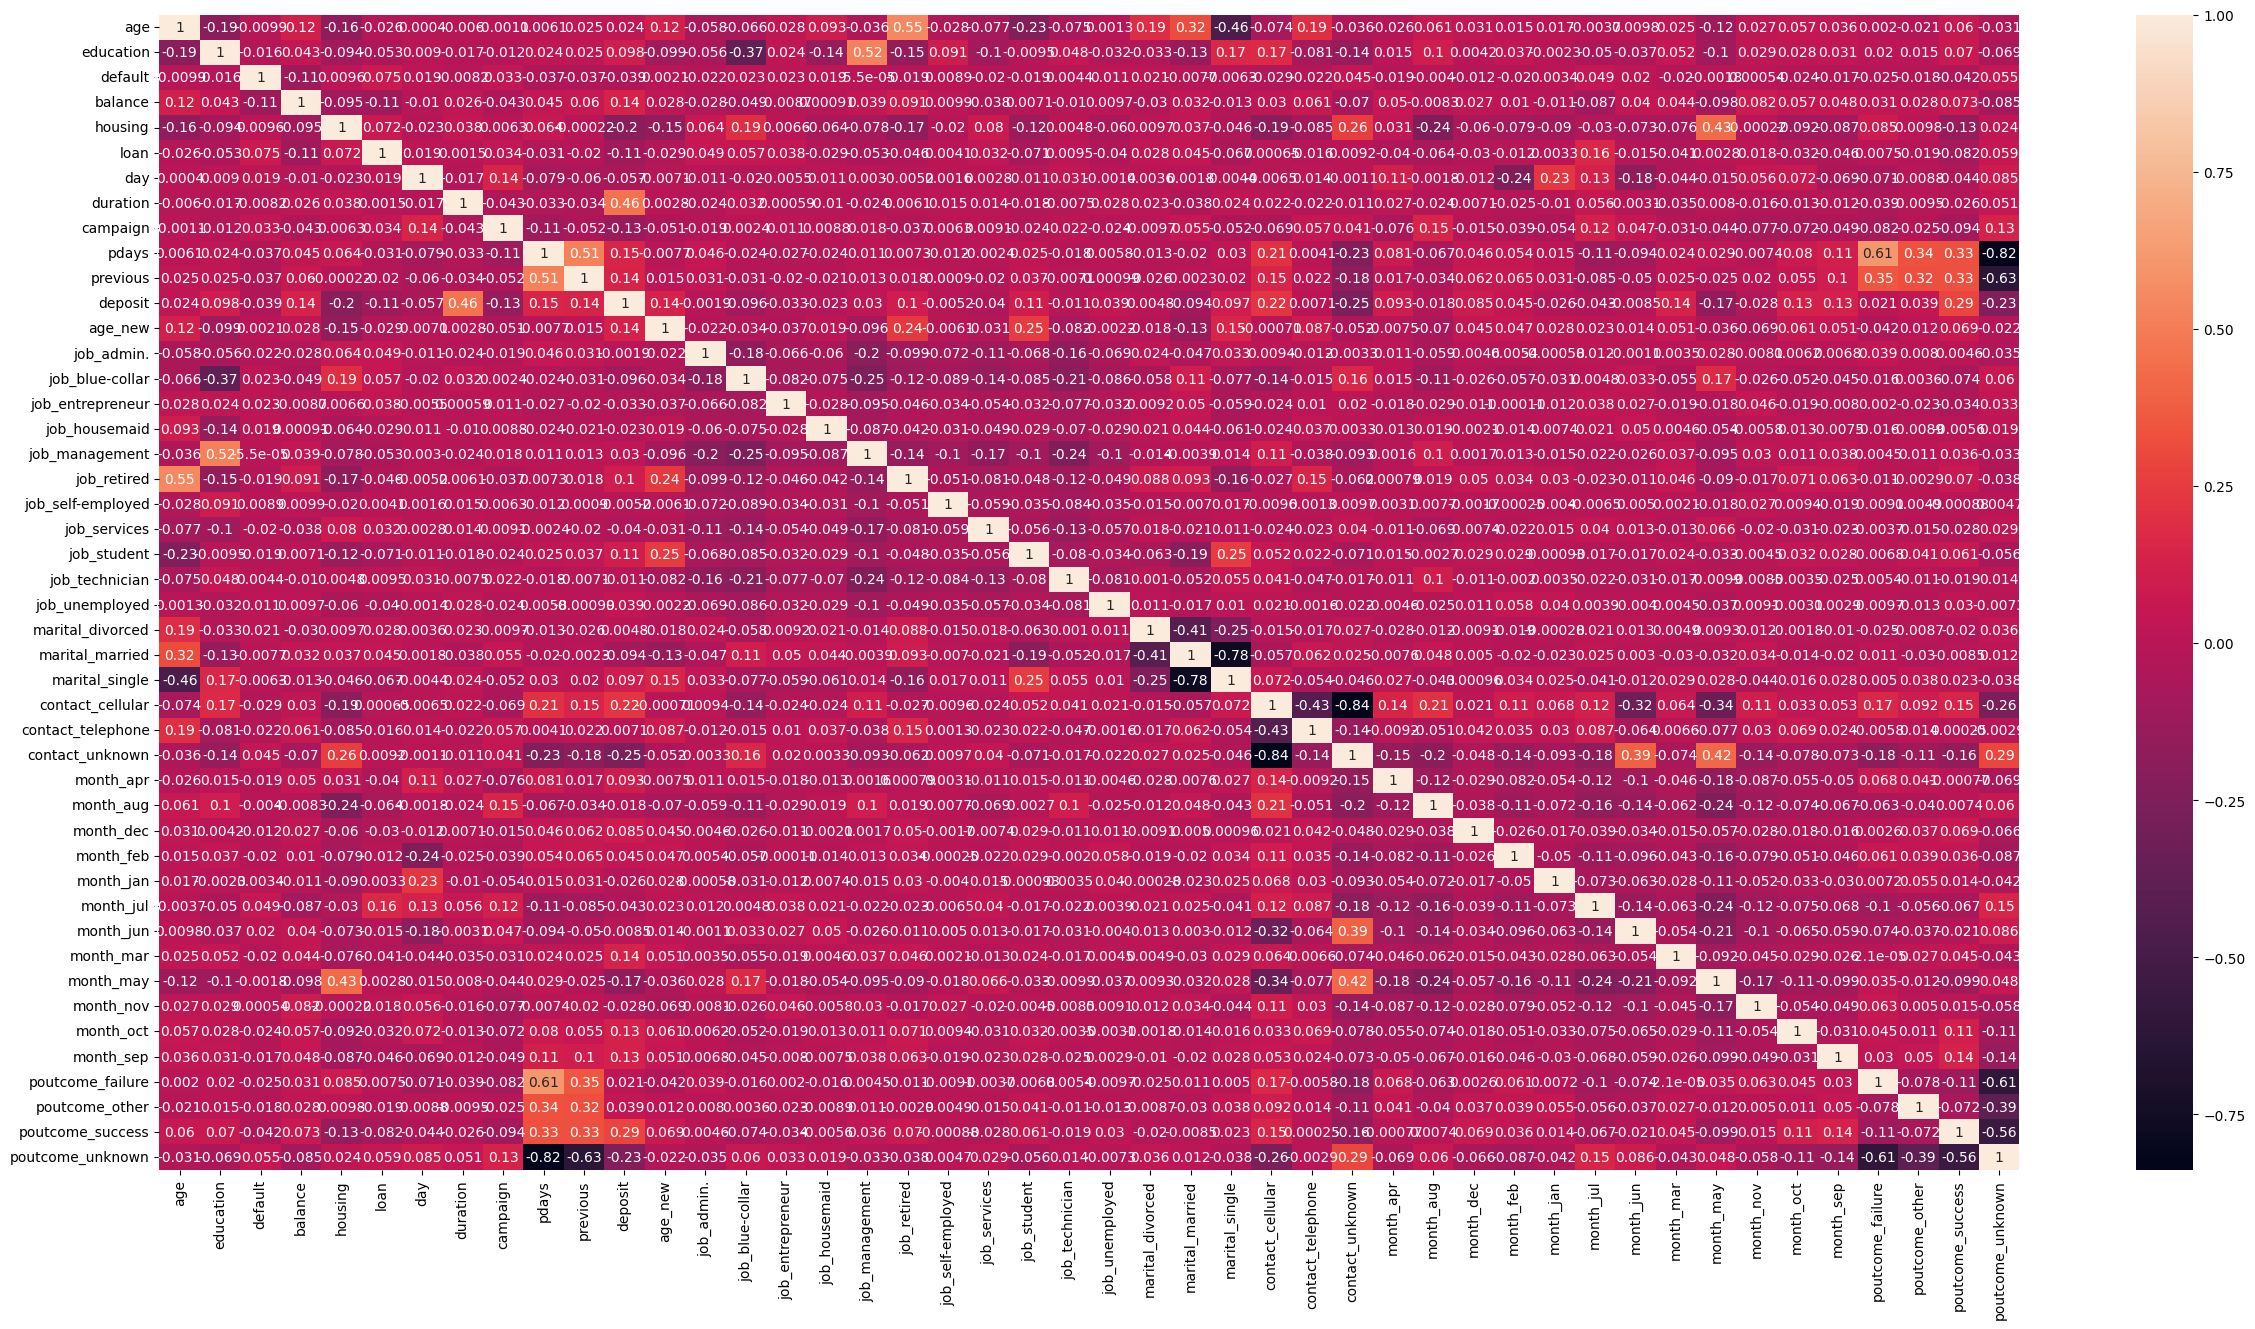

In [65]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
plt.figure(figsize = (30, 15))
sns.heatmap(df.corr(), annot = True)

In [66]:
#Вычисляем модуль корреляции
corr_with_target = df.corr()['deposit'].abs().sort_values()
#Удаляем корреляцию целевой переменной с самой собой
corr_with_target = corr_with_target.drop('deposit')
#Строим столбчатую диаграмму корреляций
fig = px.bar(
    data_frame=corr_with_target,
    y=corr_with_target.values,
    x=corr_with_target.index,
    color=corr_with_target.index,
    orientation='v',
    title='Взаимосвязь признаков с целевой переменной'
)
fig.update_layout(
    yaxis_title_text='Коэффициент корреляции',
    xaxis_title_text='Признаки',
    showlegend=False
)
fig.show()
fig.write_html("plotly/corr.html")

### Задания 7 и 8

In [67]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)
print('размер тестовой выборки:', X_test.shape, y_test.shape)

print('среднее значение целевой переменной на тестовой выборке:', round(y_test.mean(),2))

размер тестовой выборки: (3335, 45) (3335,)
среднее значение целевой переменной на тестовой выборке: 0.46


### Задание 9

In [68]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
from sklearn.feature_selection import SelectKBest, f_classif

# рассчитайте необходимые показатели
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
 
selector.get_feature_names_out()

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_new', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

In [69]:
df = df[['balance', 'housing', 'duration', 'campaign', 'pdays', 
         'previous', 'age_new', 'contact_cellular', 'contact_unknown',
         'month_mar', 'month_may', 'month_oct', 'month_sep', 'poutcome_success', 'poutcome_unknown', 'deposit']]

X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

### Задание 10

In [70]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(round(X_test_scaled[:, 0].mean(),2))

0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [72]:
# обучите логистическую регрессию и рассчитайте метрики качества
#Создаём объект класса LogisticRegression
log_reg = linear_model.LogisticRegression(solver = 'sag', random_state=42, max_iter=1000)
#Обучаем модель, минизируя logloss
log_reg.fit(X_train_scaled, y_train)
#Предсказание
y_pred_reg = log_reg.predict(X_test_scaled)
#Выводим метрики
print(metrics.classification_report(y_test, y_pred_reg))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.73      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.80      0.80      3335



### Задания 2,3,4

In [73]:
# обучите решающие деревья, настройте максимальную глубину
dt = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий эффективности
    random_state=42,#генератор случайных чисел
    max_depth= 6
)
#Обучаем модель по алгоритму CART
dt.fit(X_train_scaled, y_train)

#Делаем предсказание класса
y_pred_tree = dt.predict(X_test_scaled)
#Выводим отчёт о метриках
print(metrics.classification_report(y_test, y_pred_tree))

              precision    recall  f1-score   support

           0       0.85      0.78      0.81      1790
           1       0.77      0.84      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335



### Задание 5

In [74]:
from sklearn.model_selection import GridSearchCV

# подберите оптимальные параметры с помощью gridsearch
param = {'min_samples_split': [2, 5, 7, 10],
              'max_depth': [3, 5, 7]
              }
            
grid_search_forest = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid=param, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_forest.fit(X_train_scaled, y_train) 
y_test_pred = grid_search_forest.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))



CPU times: total: 391 ms
Wall time: 3.44 s
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 2}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [76]:
# обучите на ваших данных случайный лес
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators = 100,
    criterion = 'gini',
    min_samples_leaf = 5,
    max_depth = 10,
    random_state=42
    )

#Обучаем модель
rf.fit(X_train_scaled, y_train)
y_test_pred = rf.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))
print('accuracy на тестовом наборе: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

accuracy на тестовом наборе: 0.83


### Задания 2 и 3

In [79]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
from sklearn.ensemble import GradientBoostingClassifier

# Создаем объект класса градиентный бустинг
gb = GradientBoostingClassifier(
    learning_rate = 0.05,
    min_samples_leaf = 5,
    max_depth=5, #максимальная глубина дерева
    n_estimators=300, #количество деревьев в ансамбле
    random_state=42 #датчик генератора случайных чисел
)

# Обучаем модель
gb.fit(X_train_scaled, y_train)

# Формируем предсказание для тестовой выборки
y_test_pred = gb.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

f1_score на тестовом наборе: 0.82


### Задание 4

In [80]:
from sklearn.ensemble import StackingClassifier

# объедините уже известные вам алгоритмы с помощью стекинга 
estimators = [
    ('dt', tree.DecisionTreeClassifier(
    criterion='entropy', #критерий эффективности
    random_state=42,#генератор случайных чисел
    max_depth= 6)
    ),
    ('log_reg',  linear_model.LogisticRegression(
        solver = 'sag', 
        random_state=42, 
        max_iter=1000)
    ),
    ('gb', GradientBoostingClassifier(
    learning_rate = 0.05,
    min_samples_leaf = 5,
    max_depth=5, #максимальная глубина дерева
    n_estimators=300, #количество деревьев в ансамбле
    random_state=42) 
    ) 
]

stack = ensemble.StackingClassifier(
    estimators=estimators, #базовые модели в стекинге
    final_estimator=linear_model.LogisticRegression( #метамодель                 
        random_state=42 #датчик генератора случайных чисел
    )
)
# Обучаем модель
stack.fit(X_train_scaled, y_train)
y_stack_pred = stack.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_stack_pred))
print('precision на тестовом наборе: {:.2f}'.format(metrics.precision_score(y_test, y_stack_pred)))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1790
           1       0.80      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335

precision на тестовом наборе: 0.80


### Задание 5

In [ ]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

Признаки duration, poutcome_success и contact_unknown играют важную роль

### Задания 6,7,8

In [81]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
random_state = 42

def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score


In [85]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2023-10-06 13:00:27,721] A new study created in memory with name: RandomForestClassifier
[I 2023-10-06 13:00:28,883] Trial 0 finished with value: 0.8540168802750859 and parameters: {'n_estimators': 119, 'max_depth': 12, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8540168802750859.
[I 2023-10-06 13:00:30,829] Trial 1 finished with value: 0.8781630740393628 and parameters: {'n_estimators': 169, 'max_depth': 23, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8781630740393628.
[I 2023-10-06 13:00:32,603] Trial 2 finished with value: 0.8684498670420774 and parameters: {'n_estimators': 169, 'max_depth': 28, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8781630740393628.
[I 2023-10-06 13:00:33,928] Trial 3 finished with value: 0.8900359768496794 and parameters: {'n_estimators': 106, 'max_depth': 22, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.8900359768496794.
[I 2023-10-06 13:00:35,120] Trial 4 finished with value: 0.8443745082612116 and parameters: {'n_

CPU times: total: 35.6 s
Wall time: 36.3 s


In [89]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train_scaled, y_train)

y_test_pred = model.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_test_pred))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('accuracy_score на тестовом наборе: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

              precision    recall  f1-score   support

           0       0.85      0.81      0.83      1790
           1       0.79      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.82      0.83      0.82      3335
weighted avg       0.83      0.83      0.83      3335

f1_score на тестовом наборе: 0.82
accuracy_score на тестовом наборе: 0.83
